Use this notebook to evaluate performance of supervised and/or unsupervised approach on Test Set.

#Import Libraries and Functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from collections import defaultdict

# Supervised Learning
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

# Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, completeness_score, homogeneity_score


# PREPROCESSING

def load_dataset(filename):
    """ Load the dataset and handle errors """
    try:
        dataset = pd.read_pickle(filename)
        print(f"Dataset Loaded with {len(dataset)} rows!")
        return dataset
    except Exception as e:
        print(f"Could not load the dataset, exiting! Error: {e}")
        exit(-1)


def split_and_save_dataset(dataset, extract_rate, filenames):
    """ Split dataset and save the samples """
    # Sampling a fraction of the dataset
    sampled_df = dataset.sample(frac=extract_rate, random_state=42)
    remaining_df = dataset.drop(sampled_df.index)

    # Resetting indices
    sampled_df = sampled_df.reset_index(drop=True)
    remaining_df = remaining_df.reset_index(drop=True)

    # Save to pickle
    sampled_df.to_pickle(filenames['testing'])
    remaining_df.to_pickle(filenames['training'])

    print(f"Training dataset saved with {len(remaining_df)} rows!")
    print(f"Testing dataset saved with {len(sampled_df)} rows!")


def plot_kpi(imsi_data, kpi_column, selected_imsi):
    """ Plot the KPI over time using a stem plot """
    # Adjust 'Timestamp' to start from 0 using the smallest value as reference
    imsi_data['Adjusted_Timestamp'] = (imsi_data['Timestamp'] - imsi_data['Timestamp'].min()).dt.total_seconds()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.stem(imsi_data['Adjusted_Timestamp'], imsi_data[kpi_column], use_line_collection=True)
    plt.xlabel('Time [s]')  # Time in seconds
    plt.ylabel(kpi_column)
    plt.title(f'{kpi_column} Over Time for IMSI: {selected_imsi}')
    plt.grid(True)
    plt.tight_layout()
    #plt.show(block=False)


def plot_correlation_matrix(imsi_data):
    """ Plot the correlation matrix excluding certain columns """
    # Drop unwanted columns
    data_to_correlate = imsi_data.drop(columns=["Timestamp", "IMSI", "slice_id"], errors='ignore')

    # Compute the correlation matrix
    corr_matrix = np.round(data_to_correlate.corr(),2)

    # Plot the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Matrix for Selected IMSI")
    plt.tight_layout()
    #plt.show(block=False)

# TRAINING AND PREDICTION


def normalize_dataset(X_train, X_test):
    mean_x, std_x = X_train.mean(), X_train.std()

    X_train_norm = (X_train - mean_x) / std_x
    X_test_norm = (X_test - mean_x) / std_x

    stats_x = [mean_x, std_x]

    return X_train_norm, X_test_norm, stats_x

# supervised learning

def grid_search(classifier, parameters, train, ground_truth, pred_input, cross_val=3):

    gscv = GridSearchCV(classifier, parameters, cv=cross_val,
                        n_jobs=12, return_train_score=False,
                        verbose=5, scoring='accuracy')
    gscv.fit(train, ground_truth)

    y_pred = gscv.predict(pred_input)

    return gscv, y_pred


def get_bestpar_list(bestpar_df):


    dd = defaultdict(list)
    for index, row in bestpar_df.iterrows():  # list input dicts

        bp = row['bestpars']
        for key, value in zip(list(bp.keys()), list(bp.values())):
            dd[key] = value

    return dd

def plot_metric_supervised(perf, metric, labels, colors=None):

    fig, ax = plt.subplots(figsize=(16, 10))
    ax.bar(labels, perf, color=colors)
    plt.grid(True)
    plt.ylabel(metric)
    plt.savefig(f'{metric}_validation.png')
    #plt.show(block=False)


def print_performance_supervised(clf_name, acc, f1, y_test, output):

    print(20 * '*')
    print(f'Performance for classifier: {clf_name}')
    print(f'Accuracy --> {acc}')
    print(f'F1 Score --> {f1}')

    classes = np.unique(output)
    print("Classification report: \n", (classification_report(y_test, output)))
    cm = confusion_matrix(y_test, output, labels=classes, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classes)
    disp.plot()
    plt.savefig(f'{clf_name}_confusion.png')
    #plt.show(block=False)
    print(20 * '*')

# unsupervised learning (clustering)


def sampling_silhouette(test_data, pred_labels, ns, runs=200):
    '''

    :param test_data: input for clustering (N samples x M Features)
    :param pred_labels: output of clustering applied on test_data (N samples)
    :param ns: number of samples to take from test_data and pred_labels to make an estimate of silhouette score
    :param runs: number of ietartions over which to average
    :return: the average silhouette score over rhe number of runs
    '''

    sscores = []

    for r in range(runs):

        idx = pd.Index(np.random.choice(test_data.reset_index().index, ns, replace=False))

        x = test_data.iloc[idx]
        l = pred_labels[idx.values]

        sscores.append(silhouette_score(x,l))

    return np.mean(sscores)

def kmeans_silhouette(data, min_cl, max_cl,initialization="k-means++", estimated=False):

    '''

    :param data: input for clustering (N samples x M Features)
    :param min_cl: minimum number of clusters to test
    :param max_cl: maximum number of clusters to test
    :param initialization: centroids initialization for k means algorithm. Check sciki-learn ref for more info.
    :param estimated: Boolean, whether to opt or not for an estimated version of silhouette score
    :return: number of clusters that maximizes the silhouette score
    '''

    print(f'SILHOUETTE EVALUATION')
    silhouette_avg = []
    for num_clusters in list(range(min_cl, max_cl)):

        print(f'Clustering for k={num_clusters}...')

        if initialization not in ['k-means++', 'random']:
            init = initialization[0][:num_clusters,:initialization[1]] #select first k components as initializing centroids
        else:
            init = initialization

        kmeans = KMeans(init=init, n_clusters=num_clusters, n_init='auto')
        kmeans.fit_predict(data)

        if not estimated:
            score = silhouette_score(data, kmeans.labels_)
        else:
            score = sampling_silhouette(data, kmeans.labels_, ns=1000)
        print(f'---- Score for k={num_clusters} --> {score}')
        silhouette_avg.append(score)

        print(f'DONE')

    best_k  = np.argmax(silhouette_avg)+min_cl

    plt.figure(figsize=(12, 8))
    plt.plot(np.arange(min_cl, max_cl), silhouette_avg, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Analysis for Optimal k')
    _ = plt.xticks(np.arange(min_cl, max_cl))
    plt.grid(True)
    plt.savefig(f'Silhouette_Scores.png')
    plt.show(block=False)

    return best_k

def kmeans_helbow(data, max_cl, initialization="k-means++", ):

    '''

    :param data: input for clustering (N samples x M Features)
    :param min_cl: minimum number of clusters to test
    :param initialization: centroids initialization for k means algorithm. Check sciki-learn ref for more info.
    :return: helbow plot
    '''

    print(f'HELBOW RULE')
    distortions = []
    K = range(1, max_cl)
    for k in K:
        print(f'Clustering for k={k}...')

        if initialization not in ['k-means++', 'random']:
            init = initialization[0][:k,:initialization[1]] #select first k components as initializing centroids
        else:
            init = initialization

        kmeanModel = KMeans(init=init, n_clusters=k, n_init='auto')
        kmeanModel.fit(data)
        distortions.append(kmeanModel.inertia_)
        print(f'DONE')

    #plt.figure(figsize=(12, 8))
    fig, ax = plt.subplots(1, 1)
    ax.plot(K, distortions, 'bx-')
    plt.xlabel(r'k')
    plt.ylabel(r'Inertia')
    plt.title('Elbow Method for Optimal k')
    ax.grid(True)
    plt.savefig(f'Elbow_Rule.png')
    plt.show(block=False)

    return ax

def compute_unsupervised_performance(k, gt, test_data, pred_labels, ns):

    sscore = sampling_silhouette(test_data, pred_labels, ns=ns)
    completeness = completeness_score(gt, pred_labels)
    homogeneity = homogeneity_score(gt, pred_labels)

    print(20 * '#')
    print(f'Performance for clustering: k-means with k={k}')
    print(f'Estimated Silhouette Score --> {sscore}')
    print(f'Completeness --> {completeness}')
    print(f'Homogeneity --> {homogeneity}')
    print(20 * '#')

#Load and Preprocess/Visualize Train/Test Data

In [2]:
# Column headers
columns_list = [
    "Timestamp", "IMSI", "slice_id", "slice_prb", "scheduling_policy", "dl_mcs",
    "dl_n_samples", "dl_buffer [bytes]", "tx_brate downlink [Mbps]", "tx_pkts downlink",
    "dl_cqi", "ul_mcs", "ul_n_samples", "ul_buffer [bytes]", "rx_brate uplink [Mbps]",
    "rx_pkts uplink", "rx_errors uplink (%)", "ul_sinr", "sum_requested_prbs", "sum_granted_prbs"
]

# Dataset filenames
dataset_filenames = {
    "training": "dataset_restart_training.pkl",
    "testing": "dataset_restart_testing.pkl",
}

rs = 42

In [4]:
# Configurations
dataset_filename = dataset_filenames["training"]

# Load dataset
#train_dataset = load_dataset(train_filename)
dataset = load_dataset(dataset_filename)

# Ensure the Timestamp column is in datetime format
#train_dataset['Timestamp'] = pd.to_datetime(train_dataset['Timestamp'], errors='coerce')
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'], errors='coerce')


Dataset Loaded with 29738509 rows!


In [5]:
# Test Dataset

test_filename = 'dataset_restart_testing_fake.pkl'
test_dataset = pd.read_pickle(test_filename)

# Ensure the Timestamp column is in datetime format
#train_dataset['Timestamp'] = pd.to_datetime(train_dataset['Timestamp'], errors='coerce')
test_dataset['Timestamp'] = pd.to_datetime(test_dataset['Timestamp'], errors='coerce')

In [6]:
# Prepare Test Data for Performance Evaluation

#Training

X = dataset.drop(["Timestamp", "IMSI", "slice_id"], axis=1)
y =  dataset.loc[:, 'slice_id']

#Test
X_test = test_dataset.drop(["Timestamp", "IMSI", "slice_id"], axis=1)
y_test =  test_dataset.loc[:, 'slice_id']

X_norm, X_test_norm, stats_test = normalize_dataset(X, X_test)

# Supervised Learning: Classification

In [7]:
###### MODIFY THIS SECTION INTRODUCING YOUR CUSTOM CLASSIFIER(S)

# Put here your final Classifier(s) with Hyper-Parameters tuned
classifiers = {
    "Linear Regression": RidgeClassifier(fit_intercept=True, solver='svd')
    }




********************
Performance for classifier: Linear Regression
Accuracy --> 0.8061916003539518
F1 Score --> 0.8061916003539518
Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    526096
           1       0.69      0.77      0.73    524232
           2       0.73      0.65      0.69    514857

    accuracy                           0.81   1565185
   macro avg       0.81      0.81      0.80   1565185
weighted avg       0.81      0.81      0.81   1565185
********************


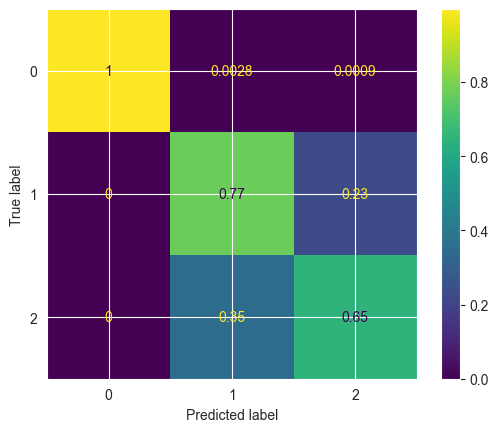

In [8]:
for i, (clf_name, clf) in enumerate(classifiers.items()):

  clf.fit(X_norm, y) #train

  output = clf.predict(X_test_norm) #predict

  f1 = f1_score(y_test, output, average='micro')
  acc = accuracy_score(y_test, output)
  print_performance_supervised(clf_name, acc, f1, y_test, output)

# Unsupervised Learning: K-Means Clustering

In [10]:
###### MODIFY THIS SECTION USING AD-HOC K FOR YOUR CUSTOM CLUSTERING CONFIGURATION

k_test =[3,4] #select best k as input hyper-parameter for clustering on test set

In [11]:
for k in k_test:

  kmeans_model = KMeans(n_clusters=k, init="k-means++", n_init='auto')


  kmeans_model.fit(X_norm) # train the model

  cluster_labels = kmeans_model.predict(X_test_norm) # assign label to test data

  compute_unsupervised_performance(k, y_test, X_test_norm, cluster_labels, ns=1000)

####################
Performance for clustering: k-means with k=3
Estimated Silhouette Score --> 0.3249765164330132
Completeness --> 0.43259163933933836
Homogeneity --> 0.38183081976476946
####################
####################
Performance for clustering: k-means with k=4
Estimated Silhouette Score --> 0.3270039354572065
Completeness --> 0.4307841401892092
Homogeneity --> 0.38181312620217606
####################
